In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.sparse as scs # sparse matrix construction 
import scipy.linalg as scl # linear algebra algorithms
import scipy.optimize as sco # for minimization use
import matplotlib.pylab as plt # for visualization
from scipy.optimize import linprog
import math
import os

data = pd.read_csv("~/Desktop/Math 110B/project1/archive/small1.csv") 
print('data set legnth:', len(data))
print(data["quizzes"][0:5])
print(data["solutions"][0:5])

data set legnth: 24
0    0800320017030800025000070300500019706007090080...
1    0000090070600008007890623504306005900905080200...
2    9004010070475080000107004080021000033090002064...
3    1000002030780264013401070000500028060800000106...
4    6002004000150000200241000031020903050305010605...
Name: quizzes, dtype: object
0    4895327617134865925629178342583419766317592489...
1    3518492672647538197891623544326715986975384215...
2    9284615376475381295137924688721569433598472164...
3    1654982739783264513421576984579128362896437156...
4    6732854918159347269241765831628973454385219675...
Name: solutions, dtype: object


In [27]:
quiz = data["quizzes"][0]
np.reshape([int(c) for c in quiz], (9,9))

array([[0, 8, 0, 0, 3, 2, 0, 0, 1],
       [7, 0, 3, 0, 8, 0, 0, 0, 2],
       [5, 0, 0, 0, 0, 7, 0, 3, 0],
       [0, 5, 0, 0, 0, 1, 9, 7, 0],
       [6, 0, 0, 7, 0, 9, 0, 0, 8],
       [0, 4, 7, 2, 0, 0, 0, 5, 0],
       [0, 2, 0, 6, 0, 0, 0, 0, 9],
       [8, 0, 0, 0, 9, 0, 3, 0, 5],
       [3, 0, 0, 8, 2, 0, 0, 1, 0]])

In [28]:
def fixed_constraints(N=9):
    rowC = np.zeros(N)
    rowC[0] =1
    rowR = np.zeros(N)
    rowR[0] =1
    row = scl.toeplitz(rowC, rowR)
    ROW = np.kron(row, np.kron(np.ones((1,N)), np.eye(N)))
    
    colR = np.kron(np.ones((1,N)), rowC)
    col  = scl.toeplitz(rowC, colR)
    COL  = np.kron(col, np.eye(N))
    
    M = int(np.sqrt(N))
    boxC = np.zeros(M)
    boxC[0]=1
    boxR = np.kron(np.ones((1, M)), boxC) 
    box = scl.toeplitz(boxC, boxR)
    box = np.kron(np.eye(M), box)
    BOX = np.kron(box, np.block([np.eye(N), np.eye(N) ,np.eye(N)]))
    
    cell = np.eye(N**2)
    CELL = np.kron(cell, np.ones((1,N)))
    
    return scs.csr_matrix(np.block([[ROW],[COL],[BOX],[CELL]]))

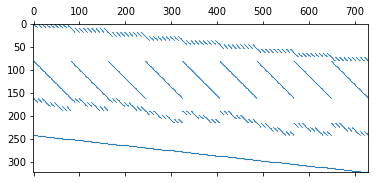

In [29]:
A0 = fixed_constraints()
plt.spy(A0, markersize=0.2)

In [30]:
def clue_constraint(input_quiz, N=9):
    m = np.reshape([int(c) for c in input_quiz], (N,N))
    r, c = np.where(m.T)
    v = np.array([m[c[d],r[d]] for d in range(len(r))])
    
    table = N * c + r
    table = np.block([[table],[v-1]])
    
    # it is faster to use lil_matrix when changing the sparse structure.
    CLUE = scs.lil_matrix((len(table.T), N**3))
    for i in range(len(table.T)):
        CLUE[i,table[0,i]*N + table[1,i]] = 1
    # change back to csr_matrix.
    CLUE = CLUE.tocsr() 
    
    return CLUE

In [32]:
import time
from scipy.linalg import LinAlgWarning
corr_cnt = 0
start = time.time()
for i in range(len(data)):
    quiz = data["quizzes"][i]
    solu = data["solutions"][i]
    A0 = fixed_constraints()
    A1 = clue_constraint(quiz)
    A = scs.vstack((A0,A1)).toarray()
    B = np.ones((np.size(A, 0)))
    u, s, vh = np.linalg.svd(A, full_matrices=False)
    K = np.sum(s > 1e-12)
    S_ = np.block([np.diag(s[:K]), np.zeros((K, A.shape[0]-K))])
    A = S_@vh
    B = u.T@B
    B = B[:K]
    c = np.block([ np.ones(A.shape[1]), np.ones(A.shape[1]) ])
    G = np.block([[-np.eye(A.shape[1]), np.zeros((A.shape[1], A.shape[1]))],\
                   [np.zeros((A.shape[1], A.shape[1])), -np.eye(A.shape[1])]])
    h = np.zeros(A.shape[1]*2)
    H = np.block([A, -A])
    b = B
    res = linprog(c, G, h, H, b, options = {'cholesky': False, 'sym_pos':False})
    X = np.array(res.x)
    x = X[:A.shape[1]] - X[A.shape[1]:]
        # map to board
    z = np.reshape(x, (81, 9))   
    if np.linalg.norm(np.reshape(np.array([np.argmax(d)+1 for d in z]), (9,9) ) \
                - np.reshape([int(c) for c in solu], (9,9)), np.inf) >0:
        pass
    else:
        #print("CORRECT")
        corr_cnt += 1
    if (i+1) % 5 == 0:
        end = time.time()
        print("Aver Time: {t:6.2f} secs. Success rate: {corr} / {all} ".format(t=(end-start)/(i+1), corr=corr_cnt, all=i+1) )

end = time.time()
print("Aver Time: {t:6.2f} secs. Success rate: {corr} / {all} ".format(t=(end-start)/(i+1), corr=corr_cnt, all=i+1) )

Aver Time:   0.32 secs. Success rate: 5 / 5 
Aver Time:   0.32 secs. Success rate: 10 / 10 
Aver Time:   0.32 secs. Success rate: 15 / 15 
Aver Time:   0.31 secs. Success rate: 20 / 20 
Aver Time:   0.31 secs. Success rate: 24 / 24 
